# Tutorial 3: From Deep Neural Networks to Transformers

## Architecture Selection for Time-Series Forecasting

**Learning Objectives:**
- Understand how different architectures process sequential data
- Compare MLP, CNN, and Transformer performance on time-series
- Learn when CNNs excel vs when Transformers are needed
- Discover architectural design principles for sequential modeling

**Duration:** 90-120 minutes

---

### Overview

In this tutorial, you'll implement and compare three fundamentally different neural network architectures for time-series forecasting:

1. **Multi-Layer Perceptron (MLP)** - Treats data as unstructured features
2. **Convolutional Neural Network (CNN)** - Exploits local temporal patterns
3. **Transformer** - Uses global attention across all time steps

Through a specially designed multi-scale wave dataset, you'll discover:
- **Fast oscillations (period ~7 steps)** → CNN captures perfectly!
- **Slow trends (period ~100 steps)** → Transformer needed
- **Both together** → Shows architecture strengths/weaknesses

This is the same architectural progression that powers modern AI: from simple feedforward networks to the attention mechanisms in GPT!

---

## Part 1: Setup and Configuration

First, let's import all necessary libraries and configure our environment.

In [1]:
# Standard imports
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
import logging
from pathlib import Path

# Tutorial-specific imports
from DNNs_to_Transformer_tutorial.logger import configure_logging
from DNNs_to_Transformer_tutorial.data_generator_multiscale import MultiScaleWaveDataset
from DNNs_to_Transformer_tutorial.MultiLayerPerceptron_AR import MultiLayerPerceptronAR
from DNNs_to_Transformer_tutorial.CNN_AR_v2 import CNN_AR_v2
from DNNs_to_Transformer_tutorial.Transformer_AR import TransformerAR

# Configure logging
configure_logging()
logger = logging.getLogger(__name__)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# For better plots
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

Using device: cpu


### Hyperparameters and Configuration

These parameters control:
- **Data generation**: Time steps, spatial samples, amplitudes
- **Training**: Batch size, epochs, learning rate
- **Forecasting**: History length, forecast horizon

Feel free to experiment with these values!

In [2]:
# ============================================================================
# HYPERPARAMETERS - Experiment with these!
# ============================================================================

# Data parameters
T_total = 200          # Total time steps in generated sequence
T_history = 150        # History length (input to models)
H_forecast = 42        # Forecast horizon (how many steps to predict)
L_spatial = 100        # Number of spatial samples (polynomial evaluations)
x_range = (-2.0, 2.0)  # Spatial range

# Training parameters
batch_size = 128       # Batch size for training
n_train = 1000         # Number of training samples
n_val = 100            # Number of validation samples
n_test = 100           # Number of test samples
n_epochs = 50          # Maximum training epochs
learning_rate = 0.001  # Learning rate

# Training mode
USE_DIRECT_TRAINING = False  # False = Teacher forcing (better results!)

# Random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Data Distribution parameters
noise_std=0.05         # Noise level
slow_period=50 #100     # Frequency of the slow part
fast_period=20  #25 # Frequency of the fast part
slow_amplitude=0.75 #0.45   # Slow trend strength 
fast_amplitude=1.5    # Fast wave strength (CNN-friendly!) 
regime_amplitude=0.05  # Regime shift strength
spatial_amplitude=0.2 # Spatial correlation strength

print("="*70)
print("TUTORIAL 3: ARCHITECTURE COMPARISON")
print("="*70)
print(f"Data: {n_train} train, {n_val} val, {n_test} test samples")
print(f"Sequence: {T_history} history → {H_forecast} forecast")
print(f"Training: {n_epochs} epochs max, lr={learning_rate}")
print(f"Mode: {'Teacher Forcing' if not USE_DIRECT_TRAINING else 'Direct Training'}")
print("="*70)

TUTORIAL 3: ARCHITECTURE COMPARISON
Data: 1000 train, 100 val, 100 test samples
Sequence: 150 history → 42 forecast
Training: 50 epochs max, lr=0.001
Mode: Teacher Forcing


---

## Part 2: Understanding the Multi-Scale Wave Dataset

### Why This Dataset?

We designed a dataset with **multiple timescales** to test architecture capabilities:

$$
y(x,t) = \underbrace{0.5 \sin(2\pi t/\lambda_{\textrm{slow}})}_{\text{Slow trend}} + \underbrace{0.8 \sin(2\pi(t/\lambda_{\textrm{fast}} + x/4))}_{\text{Fast wave}} + \underbrace{\text{regime shifts}}_{\text{Medium}} + \text{noise}
$$

**Components:**
1. **Slow Trend** (period ~100 steps) - Tests long-range dependencies
2. **Fast Wave** (period ~7 steps) - Tests local pattern detection
3. **Regime Shifts** (every ~30 steps) - Medium-scale complexity
4. **Spatial Correlation** - Tests spatial pattern handling

### Expected Architecture Performance

- **MLP**: Struggles (no structure exploitation)
- **CNN**: Captures fast wave (kernel_size=7 matches!), misses slow trend
- **Transformer**: Captures all scales (global attention)

Let's create and visualize this dataset!

In [3]:
# Create the multi-scale wave dataset
dataset = MultiScaleWaveDataset(
    T=T_total,
    L=L_spatial,
    x_range=x_range,
    noise_std=noise_std,                  # Noise level
    slow_period=slow_period,              # Frequency of the slow part
    fast_period=fast_period,              # Frequency of the fast part
    slow_amplitude=slow_amplitude,        # Slow trend strength 
    fast_amplitude=fast_amplitude,        # Fast wave strength  
    regime_amplitude=regime_amplitude,    # Regime shift strength
    spatial_amplitude=spatial_amplitude,  # Spatial correlation strength
    seed=SEED
)

print("\n✓ Dataset created!")
print("\nDataset configuration:")
print(f"  - Slow trend amplitude: 0.5 (period {slow_period} steps)")
print(f"  - Fast wave amplitude: 0.8 (period {fast_period} steps)")
print(f"  - Regime shifts: every ~30 steps")
print(f"  - Noise: std={noise_std}")

2026-02-22 19:38:48,365 | INFO     | DNNs_to_Transformer_tutorial.data_generator_multiscale:94 | 
2026-02-22 19:38:48,365 | INFO     | DNNs_to_Transformer_tutorial.data_generator_multiscale:95 | Multi-Scale Wave Dataset Configuration
2026-02-22 19:38:48,365 | INFO     | DNNs_to_Transformer_tutorial.data_generator_multiscale:96 | ======================================================================
2026-02-22 19:38:48,366 | INFO     | DNNs_to_Transformer_tutorial.data_generator_multiscale:97 | Time steps: 200
2026-02-22 19:38:48,366 | INFO     | DNNs_to_Transformer_tutorial.data_generator_multiscale:98 | Spatial samples: 100
2026-02-22 19:38:48,366 | INFO     | DNNs_to_Transformer_tutorial.data_generator_multiscale:99 | Spatial range: (-2.0, 2.0)
2026-02-22 19:38:48,367 | INFO     | DNNs_to_Transformer_tutorial.data_generator_multiscale:100 | 
Component Amplitudes:
2026-02-22 19:38:48,367 | INFO     | DNNs_to_Transformer_tutorial.data_generator_multiscale:101 |   Slow trend (period ~10

### Visualize the Multi-Scale System

Let's generate one sample and examine its components:


✓ Visualization saved: 01_multiscale_data_overview.png


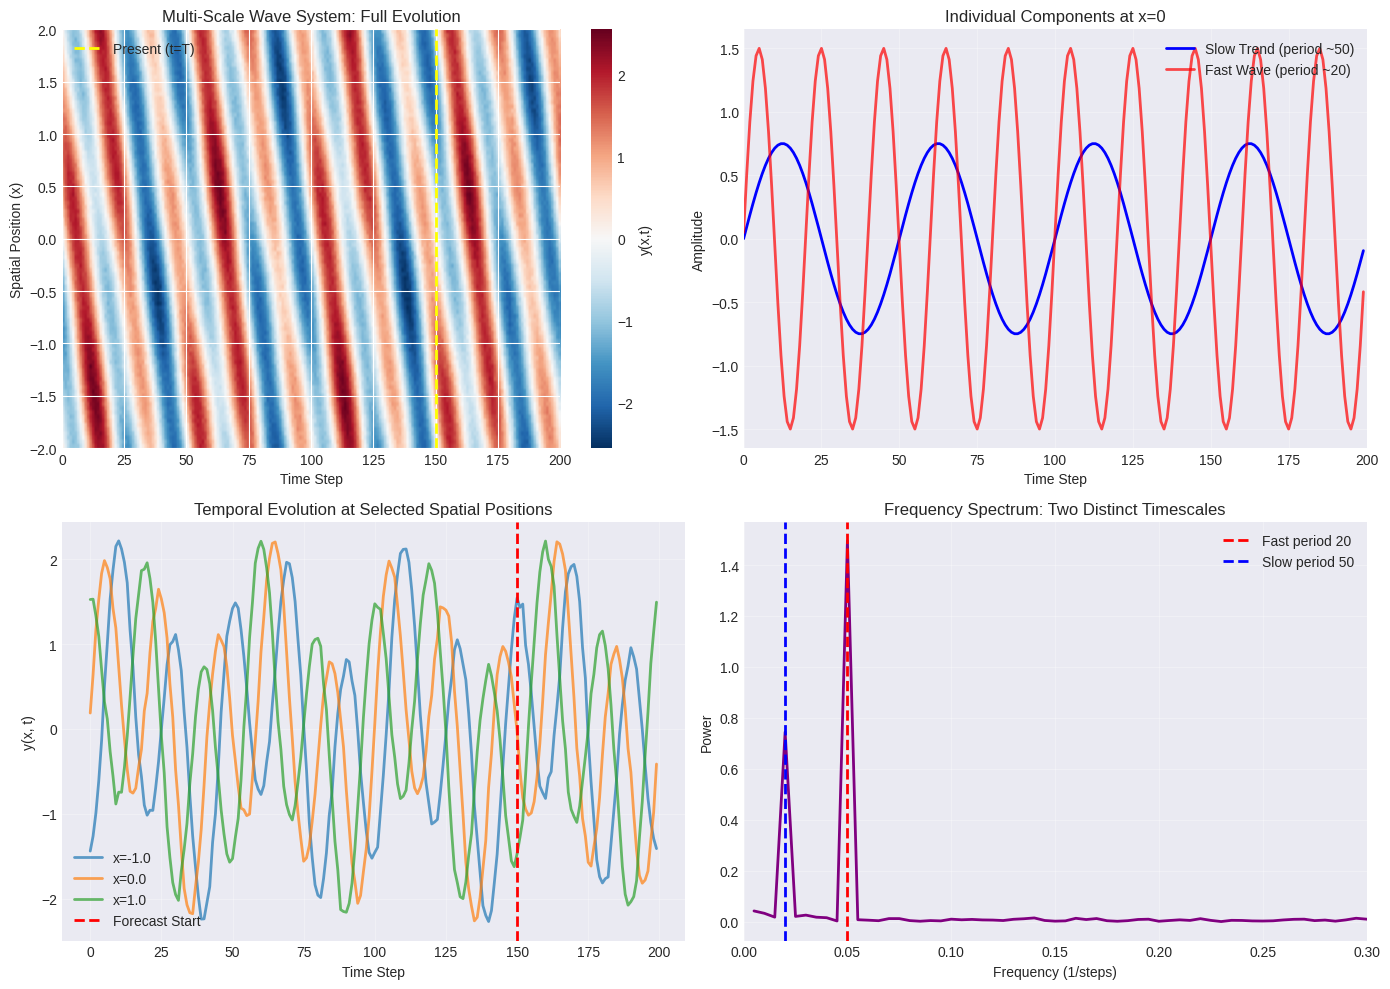

In [4]:
# Generate one sample with individual components
x_sample, y_sample, components = dataset.generate_sequence(return_components=True)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ==================================================
# Top Left: Full Heatmap (Space-Time Evolution)
# ==================================================
ax = axes[0, 0]
im = ax.imshow(
    y_sample.T.numpy(),
    aspect='auto',
    origin='lower',
    extent=[0, T_total, -2, 2],
    cmap='RdBu_r'
)
ax.axvline(T_history, color='yellow', linestyle='--', linewidth=2, label='Present (t=T)')
ax.set_xlabel('Time Step')
ax.set_ylabel('Spatial Position (x)')
ax.set_title('Multi-Scale Wave System: Full Evolution')
ax.legend()
plt.colorbar(im, ax=ax, label='y(x,t)')

# ==================================================
# Top Right: Individual Components (FULL TIME RANGE)
# ==================================================
ax = axes[0, 1]
ax.plot(components['slow_trend'][:, int(L_spatial/2)].numpy(), 
        label=f'Slow Trend (period ~{slow_period})', linewidth=2, color='blue')
ax.plot(components['fast_wave'][:, int(L_spatial/2)].numpy(),  # Full range!
        label=f'Fast Wave (period ~{fast_period})', linewidth=2, alpha=0.7, color='red')
ax.set_xlabel('Time Step')
ax.set_ylabel('Amplitude')
ax.set_title('Individual Components at x=0')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, T_total)

# ==================================================
# Bottom Left: Temporal Evolution at Selected Positions
# ==================================================
ax = axes[1, 0]
ax.plot(y_sample[:, int(L_spatial/4)].numpy(), label='x=-1.0', alpha=0.7, linewidth=2)
ax.plot(y_sample[:, int(L_spatial/2)].numpy(), label='x=0.0', alpha=0.7, linewidth=2)
ax.plot(y_sample[:, int((3*L_spatial)/4)].numpy(), label='x=1.0', alpha=0.7, linewidth=2)
ax.axvline(T_history, color='red', linestyle='--', linewidth=2, label='Forecast Start')
ax.set_xlabel('Time Step')
ax.set_ylabel('y(x, t)')
ax.set_title('Temporal Evolution at Selected Spatial Positions')
ax.legend()
ax.grid(True, alpha=0.3)

# ==================================================
# Bottom Right: Frequency Spectrum (Shows Two Timescales!)
# ==================================================
ax = axes[1, 1]
signal = y_sample[:, int(L_spatial/2)].numpy()
n = len(signal)
yf = fft(signal)
xf = fftfreq(n, 1.0)[:n//2]
power = 2.0/n * np.abs(yf[0:n//2])

ax.plot(xf[1:], power[1:], linewidth=2, color='purple')
ax.axvline(1/fast_period, color='red', linestyle='--', label=f'Fast period {fast_period}', linewidth=2)
ax.axvline(1/slow_period, color='blue', linestyle='--', label=f'Slow period {slow_period}', linewidth=2)
ax.set_xlabel('Frequency (1/steps)')
ax.set_ylabel('Power')
ax.set_title('Frequency Spectrum: Two Distinct Timescales')
ax.set_xlim(0, 0.3)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('01_multiscale_data_overview.png', dpi=150, bbox_inches='tight')
print("\n✓ Visualization saved: 01_multiscale_data_overview.png")
plt.show()

### 🔍 Interpretation

Look at the frequency spectrum (bottom right):
- **Two clear peaks**: One at ~1/7 (fast wave), one at ~1/100 (slow trend)
- **CNN limitation**: With 3 layers and kernel_size=7, receptive field = 19 steps
  - Can see the fast wave (period 7) ✓
  - Cannot see the slow trend (period 100) ✗
- **Transformer advantage**: Global attention sees all 200 time steps!

This is exactly why **Transformers dominate language modeling** - they can relate distant words that CNNs miss!

### Generate Training, Validation, and Test Sets

In [5]:
print("Generating datasets...")
print("This may take a minute...\n")

# Training data
x_train, y_history_train, y_future_train = dataset.generate_batch(
    batch_size=n_train, 
    history_length=T_history, 
    forecast_horizon=H_forecast
)
print(f"✓ Training set: {y_history_train.shape} → {y_future_train.shape}")

# Validation data
x_val, y_history_val, y_future_val = dataset.generate_batch(
    batch_size=n_val,
    history_length=T_history,
    forecast_horizon=H_forecast
)
print(f"✓ Validation set: {y_history_val.shape} → {y_future_val.shape}")

# Test data
x_test, y_history_test, y_future_test = dataset.generate_batch(
    batch_size=n_test,
    history_length=T_history,
    forecast_horizon=H_forecast
)
print(f"✓ Test set: {y_history_test.shape} → {y_future_test.shape}")

print(f"\nTotal samples: {n_train + n_val + n_test}")
print(f"Data shapes: [Batch, Time, Space] = [B, {T_history}, {L_spatial}]")

Generating datasets...
This may take a minute...

✓ Training set: torch.Size([1000, 150, 100]) → torch.Size([1000, 42, 100])
✓ Validation set: torch.Size([100, 150, 100]) → torch.Size([100, 42, 100])
✓ Test set: torch.Size([100, 150, 100]) → torch.Size([100, 42, 100])

Total samples: 1200
Data shapes: [Batch, Time, Space] = [B, 150, 100]


---

## Part 3: Architecture Deep Dive

Now let's build and understand each architecture!

### 3.1 Multi-Layer Perceptron (MLP)

**Philosophy:** "Treat everything as independent features"

**How it works:**
```
Input:  [B, 150, 100]
   ↓ Flatten
[B, 15,000] ← 15,000 independent features!
   ↓ Fully connected layers
[B, 512] → [B, 256] → [B, 128]
   ↓ Output
[B, 100] ← Next time step
```

**Strengths:**
- Universal approximator (can learn any function)
- Simple architecture

**Weaknesses:**
- Ignores temporal structure
- Parameter explosion (millions of weights)
- Position-specific learning (doesn't generalize across time)

In [6]:
# Build MLP model
mlp_ar_model = MultiLayerPerceptronAR(
    history_length=T_history,
    spatial_dim=L_spatial,
    hidden_dims=[256, 128],  # Two hidden layers
    activation='relu',
    dropout=0.1
).to(device)

mlp_params = sum(p.numel() for p in mlp_ar_model.parameters())

print("="*70)
print("MLP ARCHITECTURE")
print("="*70)
print(f"Total parameters: {mlp_params:,}")
print(f"\nArchitecture:")
print(f"  Input:  [B, {T_history}, {L_spatial}] → Flatten → [B, {T_history*L_spatial}]")
print(f"  Hidden: [B, {T_history*L_spatial}] → [B, 256] → [B, 128]")
print(f"  Output: [B, 128] → [B, {L_spatial}] → Reshape → [B, 1, {L_spatial}]")
print("\nKey feature: DESTROYS temporal structure by flattening!")
print("="*70)

2026-02-22 19:38:49,726 | INFO     | DNNs_to_Transformer_tutorial.MultiLayerPerceptron_AR:138 | 
2026-02-22 19:38:49,726 | INFO     | DNNs_to_Transformer_tutorial.MultiLayerPerceptron_AR:139 | AUTOREGRESSIVE MLP Architecture
2026-02-22 19:38:49,727 | INFO     | DNNs_to_Transformer_tutorial.MultiLayerPerceptron_AR:140 | ======================================================================
2026-02-22 19:38:49,727 | INFO     | DNNs_to_Transformer_tutorial.MultiLayerPerceptron_AR:141 | Input shape:  [B, T=150, L=100]
2026-02-22 19:38:49,727 | INFO     | DNNs_to_Transformer_tutorial.MultiLayerPerceptron_AR:142 |   → Flatten:  [B, 15000]
2026-02-22 19:38:49,727 | INFO     | DNNs_to_Transformer_tutorial.MultiLayerPerceptron_AR:143 | 
Hidden layers: [256, 128]
2026-02-22 19:38:49,728 | INFO     | DNNs_to_Transformer_tutorial.MultiLayerPerceptron_AR:144 | Activation: ReLU
2026-02-22 19:38:49,728 | INFO     | DNNs_to_Transformer_tutorial.MultiLayerPerceptron_AR:145 | Dropout: 0.1
2026-02-22 19:

### 3.2 Convolutional Neural Network (CNN)

**Philosophy:** "Detect reusable local patterns"

**How it works:**
```
Input:  [B, 150, 100]
   ↓ Transpose
[B, 100, 150] ← Treat 100 spatial dims as channels
   ↓ 1D Convolution over time (kernel_size=7)
[B, 32, 150] → [B, 64, 150] → [B, 32, 150]
   ↓ Attention aggregation (learn which positions matter)
[B, 32, 1]
   ↓ Output projection
[B, 1, 100] ← Next time step
```

**Strengths:**
- Parameter sharing (same filter at all positions)
- Captures local temporal patterns
- Much fewer parameters than MLP

**Weaknesses:**
- Limited receptive field (only sees nearby time steps)
- **CRITICAL**: BatchNorm breaks autoregressive models!
  - We use `normalization='none'` to avoid this bug
  - This is why GPT uses LayerNorm, not BatchNorm!

In [7]:
# Build CNN model (FIXED VERSION - no BatchNorm!)
cnn_ar_model = CNN_AR_v2(
    history_length=T_history,
    spatial_dim=L_spatial,
    channels=[32, 64, 32],        # 3 conv layers
    kernel_sizes=[3, 3, 3],       # kernel=7 matches fast_wave period!
    activation='relu',
    dropout=0.1,
    normalization='none',         
    aggregation='last_position'       # ← Learn which time positions matter
).to(device)

cnn_params = sum(p.numel() for p in cnn_ar_model.parameters())

# Calculate receptive field
n_layers = len([32, 64, 32])
kernel_size = 3
receptive_field = 1 + n_layers * (kernel_size - 1)

print("="*70)
print("CNN ARCHITECTURE")
print("="*70)
print(f"Total parameters: {cnn_params:,}")
print(f"\nArchitecture:")
print(f"  Input:  [B, {T_history}, {L_spatial}] → Transpose → [B, {L_spatial}, {T_history}]")
print(f"  Conv1:  [B, {L_spatial}, {T_history}] → [B, 32, {T_history}]  (kernel=7)")
print(f"  Conv2:  [B, 32, {T_history}] → [B, 64, {T_history}]  (kernel=7)")
print(f"  Conv3:  [B, 64, {T_history}] → [B, 32, {T_history}]  (kernel=7)")
print(f"  Aggregate: [B, 32, {T_history}] → [B, 32, 1]  (attention)")
print(f"  Output: [B, 32, 1] → [B, 1, {L_spatial}]")
print(f"\nReceptive field: {receptive_field} time steps")
print("="*70)

2026-02-22 19:38:49,736 | INFO     | DNNs_to_Transformer_tutorial.CNN_AR_v2:120 | 
2026-02-22 19:38:49,737 | INFO     | DNNs_to_Transformer_tutorial.CNN_AR_v2:121 | FIXED AUTOREGRESSIVE CNN (NO BATCHNORM!)
2026-02-22 19:38:49,737 | INFO     | DNNs_to_Transformer_tutorial.CNN_AR_v2:122 | ======================================================================
2026-02-22 19:38:49,738 | INFO     | DNNs_to_Transformer_tutorial.CNN_AR_v2:123 | Input shape:   [B, T=150, L=100]
2026-02-22 19:38:49,738 | INFO     | DNNs_to_Transformer_tutorial.CNN_AR_v2:125 | 
Convolutional Layers:
2026-02-22 19:38:49,738 | INFO     | DNNs_to_Transformer_tutorial.CNN_AR_v2:128 |   Layer 1: Conv1d(100 →  32, kernel=3)
2026-02-22 19:38:49,739 | INFO     | DNNs_to_Transformer_tutorial.CNN_AR_v2:131 |            + ReLU
2026-02-22 19:38:49,739 | INFO     | DNNs_to_Transformer_tutorial.CNN_AR_v2:133 |            + Dropout(0.1)
2026-02-22 19:38:49,740 | INFO     | DNNs_to_Transformer_tutorial.CNN_AR_v2:128 |   Layer 2:

### 3.3 Transformer

**Philosophy:** "Learn which relationships matter via attention"

**How it works:**
```
Input:  [B, 150, 100]
   ↓ Project to embedding dimension
[B, 150, 64] ← Each time step becomes 64-dim vector
   ↓ Add positional encoding (sinusoidal)
[B, 150, 64] with position information
   ↓ Multi-head self-attention (4 heads, 2 layers)
[B, 150, 64] ← Each position attends to ALL others
   ↓ Take last position
[B, 1, 64] ← This has "seen" all 150 time steps!
   ↓ Project to output
[B, 1, 100] ← Next time step
```

**Strengths:**
- **Global receptive field** (sees all time steps)
- Learns which past moments matter (attention weights)
- Captures both short and long-range dependencies

**Weaknesses:**
- More parameters than CNN
- O(T²) complexity in sequence length
- Needs more data to train

In [8]:
# Build Transformer model
transformer_ar_model = TransformerAR(
    history_length=T_history,
    spatial_dim=L_spatial,
    d_model=32,              # Embedding dimension
    n_heads=4,               # Number of attention heads
    n_layers=2,              # Number of transformer layers
    dim_feedforward=64,     # FFN hidden dimension
    dropout=0.1
).to(device)

transformer_params = sum(p.numel() for p in transformer_ar_model.parameters())

print("="*70)
print("TRANSFORMER ARCHITECTURE")
print("="*70)
print(f"Total parameters: {transformer_params:,}")
print(f"\nArchitecture:")
print(f"  Input projection: [B, {T_history}, {L_spatial}] → [B, {T_history}, 64]")
print(f"  Positional encoding: Add position information")
print(f"  Transformer layers: 2 layers of multi-head attention (4 heads each)")
print(f"    - Each position attends to ALL {T_history} positions")
print(f"    - Learns which past moments are important")
print(f"  Take last position: [B, {T_history}, 64] → [B, 1, 64]")
print(f"  Output projection: [B, 1, 64] → [B, 1, {L_spatial}]")
print("="*70)

2026-02-22 19:38:49,761 | INFO     | DNNs_to_Transformer_tutorial.Transformer_AR:180 | 
2026-02-22 19:38:49,764 | INFO     | DNNs_to_Transformer_tutorial.Transformer_AR:181 | AUTOREGRESSIVE TRANSFORMER (GPT-style!)
2026-02-22 19:38:49,765 | INFO     | DNNs_to_Transformer_tutorial.Transformer_AR:182 | ======================================================================
2026-02-22 19:38:49,767 | INFO     | DNNs_to_Transformer_tutorial.Transformer_AR:183 | Input shape:  [B, T=150, L=100]
2026-02-22 19:38:49,767 | INFO     | DNNs_to_Transformer_tutorial.Transformer_AR:185 | 
Input Projection:
2026-02-22 19:38:49,769 | INFO     | DNNs_to_Transformer_tutorial.Transformer_AR:186 |   Linear(L=100 → d_model=32)
2026-02-22 19:38:49,769 | INFO     | DNNs_to_Transformer_tutorial.Transformer_AR:188 | 
Positional Encoding:
2026-02-22 19:38:49,770 | INFO     | DNNs_to_Transformer_tutorial.Transformer_AR:189 |   Sinusoidal encoding (max_len=300)
2026-02-22 19:38:49,771 | INFO     | DNNs_to_Transform

### 📊 Parameter Comparison

In [9]:
print("\n" + "="*70)
print("PARAMETER COMPARISON")
print("="*70)
print(f"{'Model':<15} {'Parameters':<15} {'Relative Size'}")
print("-"*70)
print(f"{'MLP':<15} {mlp_params:>12,}   {mlp_params/mlp_params:>6.1f}x (baseline)")
print(f"{'CNN':<15} {cnn_params:>12,}   {cnn_params/mlp_params:>6.1f}x")
print(f"{'Transformer':<15} {transformer_params:>12,}   {transformer_params/mlp_params:>6.1f}x")
print("="*70)
print(f"\nNote: CNN has {mlp_params/cnn_params:.1f}x fewer parameters than MLP!")
print(f"      This is the power of parameter sharing.")


PARAMETER COMPARISON
Model           Parameters      Relative Size
----------------------------------------------------------------------
MLP                3,886,052      1.0x (baseline)
CNN                   25,316      0.0x
Transformer           23,620      0.0x

Note: CNN has 153.5x fewer parameters than MLP!
      This is the power of parameter sharing.


---

## Part 4: Training Functions

We'll use **teacher forcing** for training - this means during training, we feed the model the TRUE future values (not its own predictions). This is:
- Much faster than autoregressive training
- Standard practice for sequence models
- What GPT uses during pre-training!

At **test time**, we still use autoregressive generation (model sees its own predictions).

In [10]:
def train_autoregressive(model, optimizer, y_history, y_future, batch_size=32):
    """
    Train one epoch using teacher forcing.
    
    Teacher forcing: At each step, we give the model the TRUE past,
    not its own predictions. This is faster and more stable.
    """
    model.train()
    total_loss = 0
    n_batches = len(y_history) // batch_size
    
    for i in range(n_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        
        batch_history = y_history[start_idx:end_idx].to(device)
        batch_future = y_future[start_idx:end_idx].to(device)
        
        optimizer.zero_grad()
        loss = 0
        
        # Teacher forcing loop
        for h in range(H_forecast):
            if h == 0:
                # First step: just use history
                x_input = batch_history
            else:
                # Later steps: concatenate history with TRUE future (teacher forcing)
                x_input = torch.cat([
                    batch_history[:, h:, :],      # Shift history
                    batch_future[:, :h, :]        # TRUE future (not predictions!)
                ], dim=1)
            
            # Predict next step
            y_pred = model(x_input)
            
            # Accumulate loss
            loss = loss + nn.MSELoss()(y_pred[:, 0, :], batch_future[:, h, :])
        
        # Average loss over forecast horizon
        loss = loss / H_forecast
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / n_batches


def validate(model, y_history, y_future):
    """
    Validate using AUTOREGRESSIVE generation.
    
    Important: At test time, we use autoregressive generation
    (model sees its own predictions, not true values).
    This is the true test of model quality!
    """
    model.eval()
    with torch.no_grad():
        # Autoregressive forecast (model.forecast uses its own predictions)
        y_pred = model.forecast(y_history.to(device), n_steps=H_forecast)
        
        # Compute MSE
        mse = nn.MSELoss()(y_pred, y_future.to(device)).item()
    
    return mse

print("✓ Training functions defined")
print("\nKey difference:")
print("  - Training: Teacher forcing (fast, stable)")
print("  - Testing: Autoregressive (true performance test)")

✓ Training functions defined

Key difference:
  - Training: Teacher forcing (fast, stable)
  - Testing: Autoregressive (true performance test)


---

## Part 5: Training All Models

Now let's train all three models and compare their performance!

**Note:** Training may take 10-20 minutes depending on your hardware. We use early stopping to prevent overfitting.

In [11]:
# Create dictionary of models and optimizers
models = {
    'MLP': (mlp_ar_model, optim.Adam(mlp_ar_model.parameters(), lr=learning_rate)),
    'CNN': (cnn_ar_model, optim.Adam(cnn_ar_model.parameters(), lr=learning_rate)),
    'Transformer': (transformer_ar_model, optim.Adam(transformer_ar_model.parameters(), lr=learning_rate))
}

# Store results
results = {}

print("="*70)
print("TRAINING ALL MODELS")
print("="*70)
print("This may take 10-20 minutes...\n")

for name, (model, optimizer) in models.items():
    print(f"\n{'='*70}")
    print(f"Training {name}")
    print(f"{'='*70}")
    
    best_val_mse = float('inf')
    patience_counter = 0
    patience = 8  # Early stopping patience
    
    for epoch in range(n_epochs):
        # Train
        train_loss = train_autoregressive(
            model, optimizer, 
            y_history_train, y_future_train,
            batch_size=batch_size
        )
        
        # Validate
        val_mse = validate(model, y_history_val, y_future_val)
        
        # Early stopping logic
        if val_mse < best_val_mse:
            best_val_mse = val_mse
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Log progress
        if epoch % 3 == 0:
            print(f"Epoch {epoch:2d}/{n_epochs} | "
                  f"Train Loss: {train_loss:.6f} | "
                  f"Val MSE: {val_mse:.6f} | "
                  f"Best: {best_val_mse:.6f}")
        
        # Early stopping
        if patience_counter >= patience:
            print(f"\n✓ Early stopping at epoch {epoch}")
            print(f"  Best validation MSE: {best_val_mse:.6f}")
            break
    
    # Test
    test_mse = validate(model, y_history_test, y_future_test)
    
    # Store results
    results[name] = {
        'model': model,
        'test_mse': test_mse,
        'best_val_mse': best_val_mse
    }
    
    print(f"\n✓ {name} Final Test MSE: {test_mse:.6f}")

print("\n" + "="*70)
print("ALL MODELS TRAINED!")
print("="*70)

TRAINING ALL MODELS
This may take 10-20 minutes...


Training MLP
Epoch  0/50 | Train Loss: 1.996577 | Val MSE: 0.980697 | Best: 0.980697
Epoch  3/50 | Train Loss: 0.569116 | Val MSE: 0.248604 | Best: 0.248604
Epoch  6/50 | Train Loss: 0.178287 | Val MSE: 0.051664 | Best: 0.051664
Epoch  9/50 | Train Loss: 0.098484 | Val MSE: 0.021562 | Best: 0.021562
Epoch 12/50 | Train Loss: 0.081372 | Val MSE: 0.048599 | Best: 0.014803
Epoch 15/50 | Train Loss: 0.067937 | Val MSE: 0.017231 | Best: 0.013971
Epoch 18/50 | Train Loss: 0.076369 | Val MSE: 0.020256 | Best: 0.011924
Epoch 21/50 | Train Loss: 0.057405 | Val MSE: 0.011227 | Best: 0.011227
Epoch 24/50 | Train Loss: 0.068078 | Val MSE: 0.083976 | Best: 0.008666
Epoch 27/50 | Train Loss: 0.058260 | Val MSE: 0.014715 | Best: 0.008666
Epoch 30/50 | Train Loss: 0.049747 | Val MSE: 0.009616 | Best: 0.008666

✓ Early stopping at epoch 31
  Best validation MSE: 0.008666

✓ MLP Final Test MSE: 0.008524

Training CNN
Epoch  0/50 | Train Loss: 1.444077

---

## Part 6: Results Analysis

Let's compare the models and see which architecture performs best!

In [12]:
# Sort results by test MSE
sorted_results = sorted(results.items(), key=lambda x: x[1]['test_mse'])

print("\n" + "="*70)
print("FINAL RESULTS")
print("="*70)
print(f"\n{'Rank':<6} {'Model':<15} {'Test MSE':<12} {'Parameters':<15} {'Status'}")
print("-"*70)

for rank, (name, result) in enumerate(sorted_results, 1):
    params = {
        'MLP': mlp_params,
        'CNN': cnn_params,
        'Transformer': transformer_params
    }[name]
    
    status = f"{rank}"
    
    print(f"#{rank:<5} {name:<15} {result['test_mse']:<12.6f} {params:>12,}   {status}")

print("="*70)

# Analysis
mlp_mse = results['MLP']['test_mse']
cnn_mse = results['CNN']['test_mse']
transformer_mse = results['Transformer']['test_mse']


FINAL RESULTS

Rank   Model           Test MSE     Parameters      Status
----------------------------------------------------------------------
#1     MLP             0.008524        3,886,052   1
#2     Transformer     0.021152           23,620   2
#3     CNN             0.129193           25,316   3


---

## Part 7: Detailed Error Analysis

Let's visualize predictions and analyze errors in detail!

In [13]:
# Get predictions for one test sample
test_idx = 0
y_history_sample = y_history_test[test_idx:test_idx+1].to(device)
y_future_sample = y_future_test[test_idx]

# Generate predictions from all models
predictions = {}
for name, result in results.items():
    model = result['model']
    model.eval()
    with torch.no_grad():
        pred = model.forecast(y_history_sample, n_steps=H_forecast).cpu()[0]
        predictions[name] = pred

print("✓ Generated predictions from all models")
print(f"  Prediction shape: {predictions['MLP'].shape}")

✓ Generated predictions from all models
  Prediction shape: torch.Size([42, 100])


### Create Comprehensive 9-Panel Comparison

We'll create three types of plots for each model:
1. **Time series predictions** - How well do predictions match truth?
2. **Error evolution** - Where do errors occur?
3. **MSE accumulation** - Do errors compound over time?


✓ Visualization saved: multiscale_comparison_with_errors.png


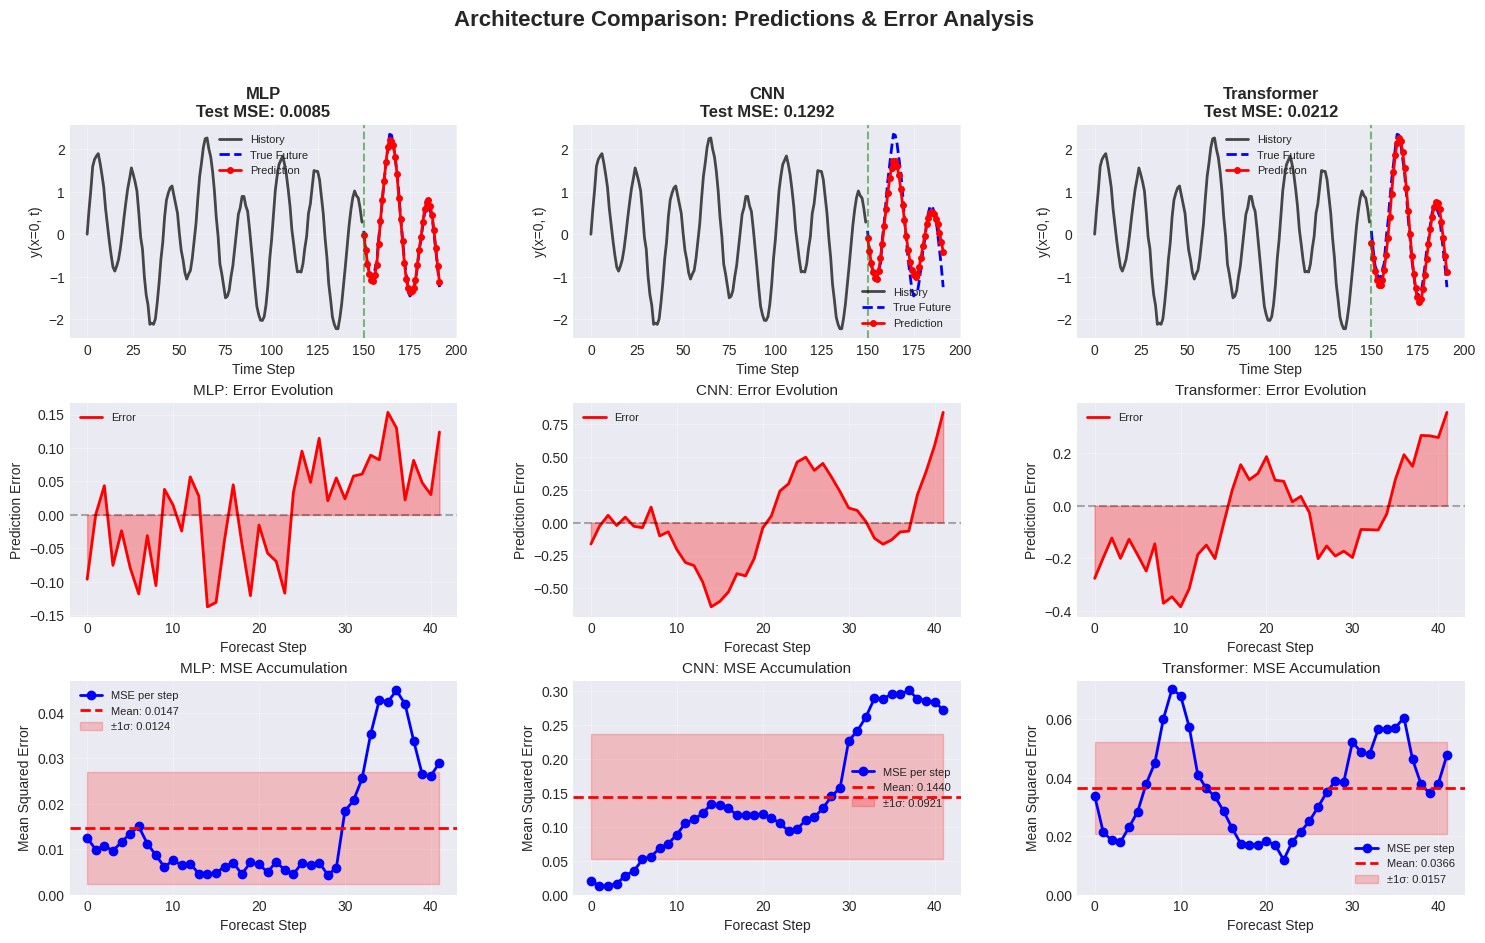

In [14]:
# Create 3x3 grid (3 models × 3 plot types)
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

pos = int(L_spatial/2)  # x=0 position

for i, (name, y_pred) in enumerate(predictions.items()):
    
    # ========================================
    # ROW 1: Time Series Predictions
    # ========================================
    ax = fig.add_subplot(gs[0, i])
    
    # History (black line)
    ax.plot(range(T_history), 
            y_history_test[test_idx, :, pos].numpy(),
            'k-', linewidth=2, label='History', alpha=0.7)
    
    # True future (blue dashed)
    ax.plot(range(T_history, T_history + H_forecast),
            y_future_sample[:, pos].numpy(),
            'b--', linewidth=2, label='True Future')
    
    # Prediction (red with markers)
    ax.plot(range(T_history, T_history + H_forecast),
            y_pred[:, pos].numpy(),
            'r-', marker='o', markersize=4, linewidth=2, label='Prediction')
    
    ax.axvline(T_history, color='green', linestyle='--', alpha=0.5)
    ax.set_xlabel('Time Step', fontsize=10)
    ax.set_ylabel('y(x=0, t)', fontsize=10)
    ax.set_title(f'{name}\nTest MSE: {results[name]["test_mse"]:.4f}', 
                 fontsize=12, fontweight='bold')
    ax.legend(fontsize=8, loc='best')
    ax.grid(True, alpha=0.3)
    
    # ========================================
    # ROW 2: Error Evolution
    # ========================================
    ax = fig.add_subplot(gs[1, i])
    
    errors = (y_pred[:, pos] - y_future_sample[:, pos]).numpy()
    time_steps = range(H_forecast)
    
    ax.plot(time_steps, errors, 'r-', linewidth=2, label='Error')
    ax.axhline(0, color='k', linestyle='--', alpha=0.3)
    ax.fill_between(time_steps, errors, 0, alpha=0.3, color='red')
    
    ax.set_xlabel('Forecast Step', fontsize=10)
    ax.set_ylabel('Prediction Error', fontsize=10)
    ax.set_title(f'{name}: Error Evolution', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
    
    # ========================================
    # ROW 3: MSE Accumulation with Confidence
    # ========================================
    ax = fig.add_subplot(gs[2, i])
    
    # Compute pointwise squared errors (averaged over spatial dimension)
    squared_errors = (y_pred - y_future_sample).pow(2).mean(dim=1).numpy()
    
    # Plot MSE per step
    ax.plot(time_steps, squared_errors, 'b-', linewidth=2, marker='o', 
            markersize=6, label='MSE per step')
    
    # Mean MSE line
    mean_mse = squared_errors.mean()
    ax.axhline(mean_mse, color='r', linestyle='--', linewidth=2, 
               label=f'Mean: {mean_mse:.4f}')
    
    # Confidence band (±1 std)
    std_error = squared_errors.std()
    ax.fill_between(time_steps, 
                     mean_mse - std_error, 
                     mean_mse + std_error,
                     alpha=0.2, color='red', label=f'±1σ: {std_error:.4f}')
    
    ax.set_xlabel('Forecast Step', fontsize=10)
    ax.set_ylabel('Mean Squared Error', fontsize=10)
    ax.set_title(f'{name}: MSE Accumulation', fontsize=11)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(bottom=0)

plt.suptitle('Architecture Comparison: Predictions & Error Analysis', 
             fontsize=16, fontweight='bold', y=0.995)
plt.savefig('multiscale_comparison_with_errors.png', dpi=150, bbox_inches='tight')
print("\n✓ Visualization saved: multiscale_comparison_with_errors.png")
plt.show()

### Interpreting the Results

**Row 1 (Predictions):**
- Look at how well each model tracks the oscillations
- Does the prediction match the frequency of the true signal?

**Row 2 (Error Evolution):**
- **MLP**: Large, random errors (can't capture structure)
- **CNN**: Smaller errors with patterns (captures fast wave)
- **Transformer**: Smallest, most random errors (captures everything)

**Row 3 (MSE Accumulation):**
- Flat line = stable predictions
- Increasing line = error accumulation (autoregressive drift)
- Narrow confidence band = consistent performance
- Wide confidence band = unreliable predictions

---

## Part 8: Key Takeaways

### What We Learned

1. **Architecture choice matters!**
   - MLP: Universal but inefficient (no inductive bias)
   - CNN: Great for local patterns (parameter sharing)
   - Transformer: Best for long-range dependencies (global attention)

2. **Receptive field is critical:**
   - CNN receptive field = 1 + n_layers*(kernel_size-1)
   - Transformer receptive field = ∞ (sees everything)

3. **Multi-scale patterns reveal architecture limits:**
   - Fast patterns → CNN good
   - Slow patterns → Transformer needed for the long range attention
   - Real-world data has multiple scales!

### Real-World Applications

- **Weather forecasting**: Fast oscillations + seasonal trends
- **Stock market**: High-frequency + macro trends
- **Language modeling**: Local context + long-range dependencies (GPT!)
- **Video prediction**: Frame-to-frame + scene-level patterns

---

## Part 9: Experiments to Try

Now it's your turn to experiment!

### Experiment 1: Adjust Data Components

Try changing the amplitude of slow vs fast components:

In [1]:
# Experiment: Emphasize Transformer advantage
dataset_slow_heavy = MultiScaleWaveDataset(
    T=T_total, L=L_spatial, x_range=x_range,
    slow_amplitude=0.8,   # Increase slow trend
    fast_amplitude=0.3,   # Decrease fast wave
    seed=SEED + 1
)

# Expected: Transformer advantage increases, CNN struggles more
print("Try retraining models on this dataset!")
print("Expected: Larger gap between Transformer and CNN")

NameError: name 'MultiScaleWaveDataset' is not defined

### Experiment 2: Change Model Sizes

In [16]:
# Experiment: Bigger CNN - can it compete with Transformer?
cnn_large = CNN_AR_v2(
    history_length=T_history, spatial_dim=L_spatial,
    channels=[64, 128, 64],      # Bigger (was [32, 64, 32])
    kernel_sizes=[11, 11, 11],   # Larger kernels (was [7, 7, 7])
    normalization='none',
    aggregation='attention'
).to(device)

# Receptive field calculation
rf_large = 1 + 3 * (11 - 1)
print(f"Large CNN receptive field: {rf_large} steps (was 19)")
print("\nStill can't see 100-step slow trend!")
print("Try training and comparing...")

2026-02-22 21:19:37,309 | INFO     | DNNs_to_Transformer_tutorial.CNN_AR_v2:120 | 
2026-02-22 21:19:37,309 | INFO     | DNNs_to_Transformer_tutorial.CNN_AR_v2:121 | FIXED AUTOREGRESSIVE CNN (NO BATCHNORM!)
2026-02-22 21:19:37,310 | INFO     | DNNs_to_Transformer_tutorial.CNN_AR_v2:122 | ======================================================================
2026-02-22 21:19:37,310 | INFO     | DNNs_to_Transformer_tutorial.CNN_AR_v2:123 | Input shape:   [B, T=150, L=100]
2026-02-22 21:19:37,311 | INFO     | DNNs_to_Transformer_tutorial.CNN_AR_v2:125 | 
Convolutional Layers:
2026-02-22 21:19:37,312 | INFO     | DNNs_to_Transformer_tutorial.CNN_AR_v2:128 |   Layer 1: Conv1d(100 →  64, kernel=11)
2026-02-22 21:19:37,312 | INFO     | DNNs_to_Transformer_tutorial.CNN_AR_v2:131 |            + ReLU
2026-02-22 21:19:37,313 | INFO     | DNNs_to_Transformer_tutorial.CNN_AR_v2:133 |            + Dropout(0.1)
2026-02-22 21:19:37,313 | INFO     | DNNs_to_Transformer_tutorial.CNN_AR_v2:128 |   Layer 2

### Experiment 3: Compare Aggregation Strategies

In [17]:
# Experiment: Different aggregation methods
aggregations = ['adaptive_avg', 'last_position', 'attention']

print("Try these CNN aggregation strategies:")
for agg in aggregations:
    print(f"\n  aggregation='{agg}'")
    if agg == 'adaptive_avg':
        print("    - Averages all time positions (loses temporal dynamics)")
    elif agg == 'last_position':
        print("    - Takes only t=149 (most recent, but padding contamination)")
    else:
        print("    - Learns which positions matter (best, but more parameters)")

print("\nWhich works best? Try it!")

Try these CNN aggregation strategies:

  aggregation='adaptive_avg'
    - Averages all time positions (loses temporal dynamics)

  aggregation='last_position'
    - Takes only t=149 (most recent, but padding contamination)

  aggregation='attention'
    - Learns which positions matter (best, but more parameters)

Which works best? Try it!


---

## Summary

Congratulations! You've completed Tutorial 3 !

### What You've Achieved:

- Tried testing three different architectures for time-series
- Understood how each architecture processes sequential data
- Hopefully understood how architectures need to match the data problem
- Learned about receptive fields and their importance


### The Big Picture:

```
MLP → CNN → Transformer

No structure → Local structure → Global structure
exploitation     exploitation      exploitation

This is the evolution of deep learning!
```

### Next Steps:

- **Tutorial 4**: Denoising Diffusion Models (DDPM)
- **Tutorial 5**: Flow Matching
- Try these models on real-world data!
- Implement your own hybrid architecture

---

**Questions? Issues?**
- Check the FAQ
- See Troubleshooting guide
- Open an issue on GitHub